In [11]:
import os
import pandapower as pp
import pandapower.networks as pn
import networkx as nx
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from scipy.stats import mode
import osmnx as ox

# Import our custom Bayesian model classes

from bayesgrid import BayesianPowerModel, BayesianFrequencyModel, BayesianDurationModel, BayesianImpedanceModel

from bayesgrid import create_osm_pandapower_network,save_bus_metric_samples,save_power_phase_samples,save_impedance_samples


# Suppress warnings for a cleaner tutorial
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("Libraries imported successfully.")

Libraries imported successfully.



# Tutorial 2: Generating a Synthetic Grid from OpenStreetMap

This tutorial demonstrates the full power of `bayesgrid`: creating a complete, synthetic distribution network from scratch using real-world data from OpenStreetMap (OSM).

While Tutorial 1 showed how to use an *existing* `pandapower` test case, this guide will show you how to generate your own network topology based on any location, such as a city, a specific address, or a set of coordinates.

We will cover the complete workflow:
1.  **Define helper functions** to query OSM and process the graph data.
2.  **Create a `pandapower` network** from an OSM road network, including radializing the graph and setting a substation.
3.  **Load the pre-trained `bayesgrid` models.**
4.  **Calculate the hop distances** for the new OSM-based network.
5.  **Generate a full set of synthetic data** (Power, Phase, Reliability, Impedance) for this new network.
6.  **Save all samples** to `.csv` files for analysis or export.






# Step 1: Creating a Pandapower network from OpenStreetMap

In this step, we use the `create_osm_pandapower_network` function to generate our grid topology.

It is important to note that, regardless of the specific query method chosen (City, Point, Bounding Box, or Address), `bayesgrid` consistently returns two key objects:
1.  **A Pandapower network**
2.  **A NetworkX graph**

The **Pandapower network** is the essential input for the subsequent steps. It serves as the physical skeleton upon which the four Bayesian models will generate synthetic data (power, impedance, and reliability metrics).

The **NetworkX graph** is not strictly required for the parameter generation phase. However, it preserves the raw graph structure, which is useful for calculating graph-theoretical properties (such as centrality or path operations). Additionally, this graph object will be required in **Tutorial 5** to perform geospatial visualizations of the generated samples.

Below, we demonstrate all four query methods to highlight the tool's flexibility. However, for the remainder of this tutorial, we will proceed using the network generated by the **City Name** query.

## Example 1: This is the simplest way. Just provide a city and country.

In [2]:

query_city = "Guaraçai, Brazil"
net_city, tree_graph_city = create_osm_pandapower_network(query_city, query_type='city')



print(f"\nCreated network for {query_city}.")
print(net_city)

Fetching graph for query 'Guaraçai, Brazil' (type: city)...
No substation_point provided. Finding graph center...
Using graph center: (-21.0402, -51.2241)
Substation node selected: 353411112
Radializing graph from source node 353411112...
Original graph: 459 nodes, 689 edges
Radial tree: 459 nodes, 458 edges
Converting NetworkX graph to pandapower network...
Created 459 buses.
Created 458 lines.
Added External Grid at bus 0 (Node 353411112).

--- OSM pandapower network creation complete! ---

Created network for Guaraçai, Brazil.
This pandapower network includes the following parameter tables:
   - bus (459 elements)
   - ext_grid (1 element)
   - line (458 elements)


## Example 2: By Point + Radius
Useful for modeling a specific neighborhood.

In [12]:
# A point in Santo Amaro, São Paulo
query_point = (-23.649, -46.702) 

# We can specify a different line type for this network
net_point, tree_graph_point = create_osm_pandapower_network(
    query_point, 
    query_type='point', 
    dist=1500, # 1500-meter radius
    line_std_type="48-AL1/8-ST1A 20.0" # Example of a different standard
)
print(net_point)

Fetching graph for query '(-23.649, -46.702)' (type: point)...
No substation_point provided. Finding graph center...
Using graph center: (-23.6488, -46.7023)
Substation node selected: 2380734697
Radializing graph from source node 2380734697...
Original graph: 951 nodes, 1422 edges
Radial tree: 951 nodes, 950 edges
Converting NetworkX graph to pandapower network...
Created 951 buses.
Created 950 lines.
Added External Grid at bus 0 (Node 2380734697).

--- OSM pandapower network creation complete! ---
This pandapower network includes the following parameter tables:
   - bus (951 elements)
   - ext_grid (1 element)
   - line (950 elements)


## Example 3: By Bounding Box
Useful if you have exact map coordinates.

In [4]:
# A small bounding box in New York City
query_bbox = {
    'north': 40.715, 'south': 40.710,
    'east': -74.005, 'west': -74.010
}
net_bbox, tree_graph_bbox = create_osm_pandapower_network(query_bbox, query_type='bbox')
print(net_bbox)

Fetching graph for query '{'north': 40.715, 'south': 40.71, 'east': -74.005, 'west': -74.01}' (type: bbox)...
No substation_point provided. Finding graph center...
Using graph center: (40.7122, -74.0077)
Substation node selected: 2821304138
Radializing graph from source node 2821304138...
Original graph: 30 nodes, 40 edges
Radial tree: 30 nodes, 29 edges
Converting NetworkX graph to pandapower network...
Created 30 buses.
Created 29 lines.
Added External Grid at bus 0 (Node 2821304138).

--- OSM pandapower network creation complete! ---
This pandapower network includes the following parameter tables:
   - bus (30 elements)
   - ext_grid (1 element)
   - line (29 elements)


## Example 4: By Address
Combines geocoding (finding coordinates) with the point query.

In [5]:
query_address = "São Carlos City Center, Brazil"
net_address, tree_graph_address = create_osm_pandapower_network(
    query_address, 
    query_type='address', 
    dist=100 # 100-meter radius around the address
)
print(net_address)

Fetching graph for query 'São Carlos City Center, Brazil' (type: address)...
No substation_point provided. Finding graph center...
Using graph center: (-22.0676, -46.9741)
Substation node selected: 1850349272
Radializing graph from source node 1850349272...
Original graph: 6 nodes, 7 edges
Radial tree: 6 nodes, 5 edges
Converting NetworkX graph to pandapower network...
Created 6 buses.
Created 5 lines.
Added External Grid at bus 0 (Node 1850349272).

--- OSM pandapower network creation complete! ---
This pandapower network includes the following parameter tables:
   - bus (6 elements)
   - ext_grid (1 element)
   - line (5 elements)


# Step 2: Visualize the Radial Network
We can visualize any of the networks we just created. For this tutorial we will visualize the point + radius one (example 2)

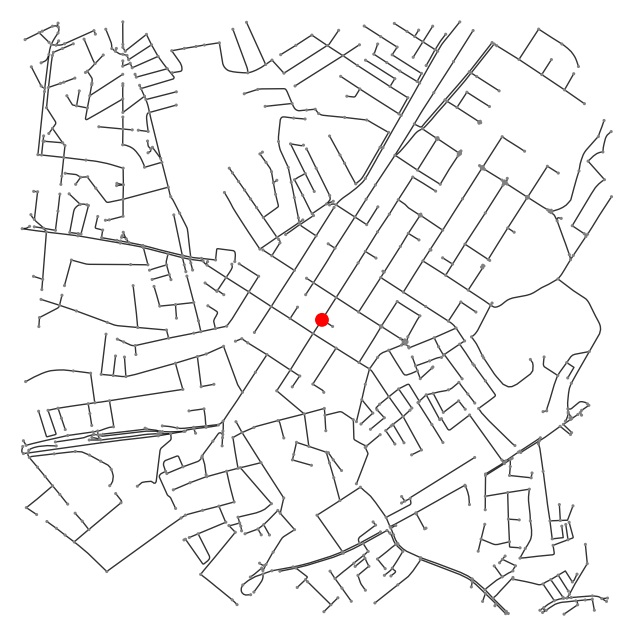

In [13]:
net = net_point
tree_graph = tree_graph_point

# Keep these for the next steps
source_bus = net.ext_grid.bus.iloc[0] # This will be 0
graph_from_net = pn.create_nxgraph(net)



substation_node = net.bus.name.iloc[source_bus] # Get original osmnx node ID

# --- 1. Prepare Node Colors and Sizes ---
node_colors = []
node_sizes = []
for node in tree_graph.nodes():
    if str(node) == substation_node:
        node_colors.append('red')   # Highlight color for the substation
        node_sizes.append(100)      # Make it larger
    else:
        node_colors.append('gray')  # Color for other nodes
        node_sizes.append(5)        # Make other nodes small

# --- 2. Create and Customize the Plot ---
fig, ax = ox.plot_graph(
    tree_graph,
    node_color=node_colors,
    node_size=node_sizes,
    node_zorder=2,
    edge_color='black',
    edge_linewidth=1.0,
    edge_alpha=0.8,
    bgcolor='white',
    show=False,
    close=False
)


# Step 3: initialize each bayesiam model and sample from it

* Please be aware: in the background, the traces from the bayesian models are being loaded. This may take some time. 

* The traces being loaded represents previous knowledge learned from a public database. It is possible to create a bayesian model from your own data. To learn how to do it, see tutorial 3: Learning the bayesian model from new data

* For all bayseian models, the only required input is the panda power `net` object, created using any of the 4 queries options presented in this tutorial. For now we will visualize the point + radius one (example 2)


In [14]:
net = net_point

N_SAMPLES_TO_GENERATE = 1000 # We will generate 1000 synthetic network samples per trace. There are 4 traces, so a total of 4000 samples will be generated.
OUTPUT_FOLDER = 'new_osm_synthetic_net_v2' # Folder to save our results

# Step 4: Generate All Synthetic Data


The only required inputs for each bayesian model are the generated pandapower networks.



## 4.1) Power Model

* You can define the total demand for the power model, if you want. This will be the total active power (in kW) to be splitted across the buses.

In [15]:
bpm = BayesianPowerModel(total_demand=1e3) # 1 GW of total demand


print("\nGenerating Power and Phase...")
gen_phases, gen_power = bpm.generate_data(
    net = net
)
print(f"Power/Phase shape: {gen_power.shape}")

No trace_path provided. Fetching default pre-trained model...
Loading trace from C:\Users\hoc\AppData\Local\bayesgrid\bayesgrid\Cache\trace_power_and_phase.nc...
Successfully loaded pre-trained model.
Model was trained with 3599 buses and 10 zones.

Generating Power and Phase...
Created 951 bus zone indices for power (10 bins).
Step 1: Generating unconstrained data for 951 buses...


Sampling: [a_by_zone, phase_likelihood, power_observed, probs]


Step 1 complete.
Step 2: Calculating phase probabilities...
Step 2a: Analyzing graph topology...
Found 564 ramification nodes.
Step 3: Building graph-consistency scan model for 564 ramification nodes...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 2347 seconds.


Step 5: Mapping consistent phases to full grid...
--- Generation Complete ---
Step 6: Re-allocating power based on consistent phases...
--- Generation Complete ---
Power/Phase shape: (4000, 951, 3)


## 4.2) Failure Duration Model

In [16]:
# 2. Duration Model
bdm = BayesianDurationModel()

print("\nGenerating Failure Duration (CAIDI/DIC)...")
gen_dur_all = bdm.generate_data(
    net = net
)
print(f"Duration shape: {gen_dur_all.shape}")


No trace_path provided. Fetching default pre-trained model...
Loading trace from C:\Users\hoc\AppData\Local\bayesgrid\bayesgrid\Cache\trace_dic.nc...
Successfully loaded pre-trained model.
Model was trained with 13547 total buses
(8299 positive) and 30 zones.

Generating Failure Duration (CAIDI/DIC)...
Max hop distance found: 29
Created 951 bus zone indices for reliability (30 bins).

--- Part 1: Predicting the Hurdle for 951 buses ---
New network is smaller or same size. Using padding...


Sampling: [observed_hurdle]



--- Part 2: Generating Potential Positive Durations ---

--- Part 3: Combining Hurdle and Duration Samples ---

--- Simulation Complete ---
Shape of final samples: (4000, 951)
Duration shape: (4000, 951)


## 4.3) Failure Frequency Model

In [17]:
# 3. Frequency Model
bfm = BayesianFrequencyModel()

print("\nGenerating Failure Frequency (CAIFI/FIC)...")
gen_freq_all = bfm.generate_data(
    net = net
)


No trace_path provided. Fetching default pre-trained model...
Loading trace from C:\Users\hoc\AppData\Local\bayesgrid\bayesgrid\Cache\trace_fic.nc...
Successfully loaded pre-trained model.
Model was trained with 9328 buses and 30 zones.

Generating Failure Frequency (CAIFI/FIC)...
Max hop distance found: 29
Created 951 bus zone indices for reliability (30 bins).
New network is smaller or same size. Using padding...


Sampling: [frequency_likelihood]



--- Simulation Complete ---
Shape of final samples: (4000, 951)


In [18]:
gen_freq = gen_freq_all
print(f"Frequency shape: {gen_freq.shape}")

Frequency shape: (4000, 951)


## 4.4) Line Impedance Model

In [19]:

# 4. Impedance Model (R and X)
bim = BayesianImpedanceModel()

# --- 4. Generate R1 and X1 Impedance ---
print("\nGenerating Line Impedance (R1/X1)...")
gen_r, gen_x = bim.generate_data(
    net = net
)

print("\n--- All Generation Complete ---")
print(f"R1 shape: {gen_r.shape}, X1 shape: {gen_x.shape}")

Fetching default R-model trace...
Fetching default X-model trace...
Loading R1 trace from C:\Users\hoc\AppData\Local\bayesgrid\bayesgrid\Cache\trace_r.nc...
R1 model loaded. Trained with 10353 lines and 10 zones.
Loading X1 trace from C:\Users\hoc\AppData\Local\bayesgrid\bayesgrid\Cache\trace_x.nc...
X1 model loaded. Trained with 10353 lines and 10 zones.

Generating Line Impedance (R1/X1)...
Calculating hop distances for all buses in the OSM network...
Max hop distance found: 29
Created 951 bus zone indices for power (10 bins).
Created 950 line zone indices for impedance (10 bins).
Generating R1 samples for 950 lines...


Sampling: [r1_likelihood]


Generating X1 samples for 950 lines...


Sampling: [x1_likelihood]



--- Simulation Complete ---
R1 samples shape: (4000, 950)
X1 samples shape: (4000, 950)

--- All Generation Complete ---
R1 shape: (4000, 950), X1 shape: (4000, 950)


# Step 6: Post-Process and Save All Samples
Finally, we save all N_SAMPLES_TO_GENERATE into our new output folder, new_osm_synthetic_net.

In [20]:
N_SAMPLES_TO_GENERATE = 1000

gen_power = gen_power[:N_SAMPLES_TO_GENERATE, :, :]

gen_phases = gen_phases[:N_SAMPLES_TO_GENERATE, :]

gen_freq = gen_freq[:N_SAMPLES_TO_GENERATE, :]

gen_dur = gen_dur_all[:N_SAMPLES_TO_GENERATE, :]

gen_r = gen_r[:N_SAMPLES_TO_GENERATE, :]

gen_x = gen_x[:N_SAMPLES_TO_GENERATE, :]

In [25]:
gen_power.shape

(1000, 951, 3)

In [30]:
OUTPUT_FOLDER

'new_osm_synthetic_net_v2'

In [23]:
print(f"Processing all {N_SAMPLES_TO_GENERATE} samples and saving to folder: '{OUTPUT_FOLDER}'")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 1. Save Power and Phase
save_power_phase_samples(
    gen_phases=gen_phases,
    gen_power=gen_power,
    bus_index=net.bus.index,
    phase_map=bpm.get_phase_map(),
    n_samples=N_SAMPLES_TO_GENERATE,
    output_path=os.path.join(OUTPUT_FOLDER, 'bus_power_and_phase_SAMPLES.csv')
)

# 2. Save Frequency
save_bus_metric_samples(
    gen_data=gen_freq,
    col_name='CAIFI_FIC',
    bus_index=net.bus.index,
    n_samples=N_SAMPLES_TO_GENERATE,
    output_path=os.path.join(OUTPUT_FOLDER, 'bus_frequency_SAMPLES.csv')
)

# 3. Save Duration
save_bus_metric_samples(
    gen_data=gen_dur,
    col_name='CAIDI_DIC',
    bus_index=net.bus.index,
    n_samples=N_SAMPLES_TO_GENERATE,
    output_path=os.path.join(OUTPUT_FOLDER, 'bus_duration_SAMPLES.csv')
)

# 4. Save Impedance
save_impedance_samples(
    gen_r=gen_r,
    gen_x=gen_x,
    line_index=net.line.index,
    n_samples=N_SAMPLES_TO_GENERATE,
    output_path=os.path.join(OUTPUT_FOLDER, 'line_impedance_SAMPLES.csv')
)

print("\n--- All Synthetic Data Samples Saved Successfully! ---")

Processing all 1000 samples and saving to folder: 'new_osm_synthetic_net_v2'
Processing Power & Phase...
Saved 'bus_power_and_phase_SAMPLES.csv' with 951000 rows.
Processing CAIFI_FIC...
Saved 'bus_frequency_SAMPLES.csv' with 951000 rows.
Processing CAIDI_DIC...
Saved 'bus_duration_SAMPLES.csv' with 951000 rows.
Processing Impedance...
Saved 'line_impedance_SAMPLES.csv' with 950000 rows.

--- All Synthetic Data Samples Saved Successfully! ---


In [24]:
pp.to_pickle(net,os.path.join(OUTPUT_FOLDER,'pandapower_network.p'))

# Tutorial Complete
You have successfully started from a simple OpenStreetMap query (address, bounding box, point location, city name); downloaded real-world map data;  converted it into a radial pandapower network, and generated a full set of N_SAMPLES_TO_GENERATE synthetic parameters for it.